## Simulate and Plot Data

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

# hack to be able to import modules from src/pfjax
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# from src.pfjax import particle_filter as pf
# from src.pfjax import particle_filter_mvn as pfmvn
# from src.pfjax.particle_filter import joint_loglik, particle_loglik, simulate
# from src.pfjax import proj_data
# from src.pfjax.lotvol_model import LotVolModel
# from src.pfjax.bm_model import BMModel

from pfjax.particle_filter import particle_filter as pf
from pfjax import particle_filter_mvn as pfmvn
from pfjax.particle_filter import joint_loglik, particle_loglik, simulate
from pfjax import proj_data
from pfjax.lotvol_model import LotVolModel

In [18]:
# def meas_sim(model, n_obs, x_init, theta, key):
#     """
#     Simulate data from the state-space model.
#     Args:
#         model: Object specifying the state-space model.
#         n_obs: Number of observations to generate.
#         x_init: Initial state value at time `t = 0`.
#         theta: Parameter value.
#         key: PRNG key.
#     Returns:
#         y_meas: The sequence of measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
#         x_state: The sequence of state variables `x_state = (x_0, ..., x_T)`, where `T = n_obs-1`.
#     """
#     # lax.scan setup
#     # scan function
#     def fun(carry, x):
#         key, *subkeys = random.split(carry["key"], num=3)
#         x_state = model.state_sample(carry["x_state"], theta, subkeys[0])
#         y_meas = model.meas_sample(x_state, theta, subkeys[1])
#         res = {"y_meas": y_meas, "x_state": x_state, "key": key}
#         return res, res
#     # scan initial value
#     key, subkey = random.split(key)
#     init = {
#         "y_meas": model.meas_sample(x_init, theta, subkey),
#         "x_state": x_init,
#         "key": key
#     }
#     # scan itself
#     last, full = lax.scan(fun, init, jnp.arange(1, n_obs))
#     # append initial values
#     x_state = jnp.append(jnp.expand_dims(init["x_state"], axis=0),
#                          full["x_state"], axis=0)
#     y_meas = jnp.append(jnp.expand_dims(init["y_meas"], axis=0),
#                         full["y_meas"], axis=0)
#     return y_meas, x_state

In [19]:
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)


x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

y_meas, x_state = simulate(lotvol_model, n_obs, x_init, theta, subkey)

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

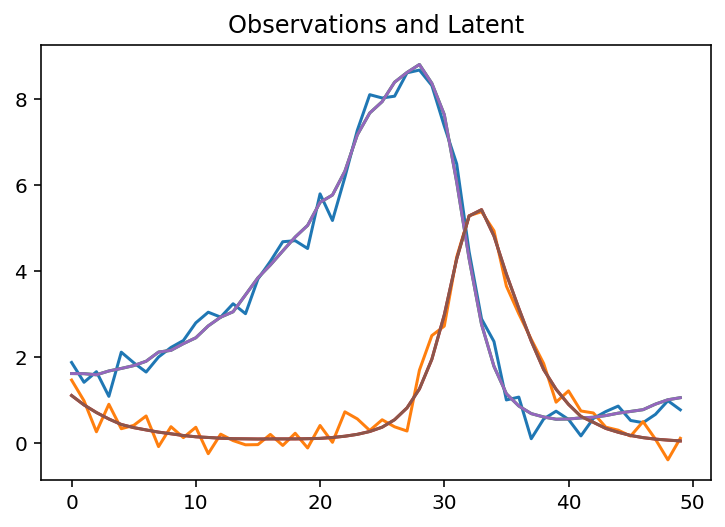

In [20]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

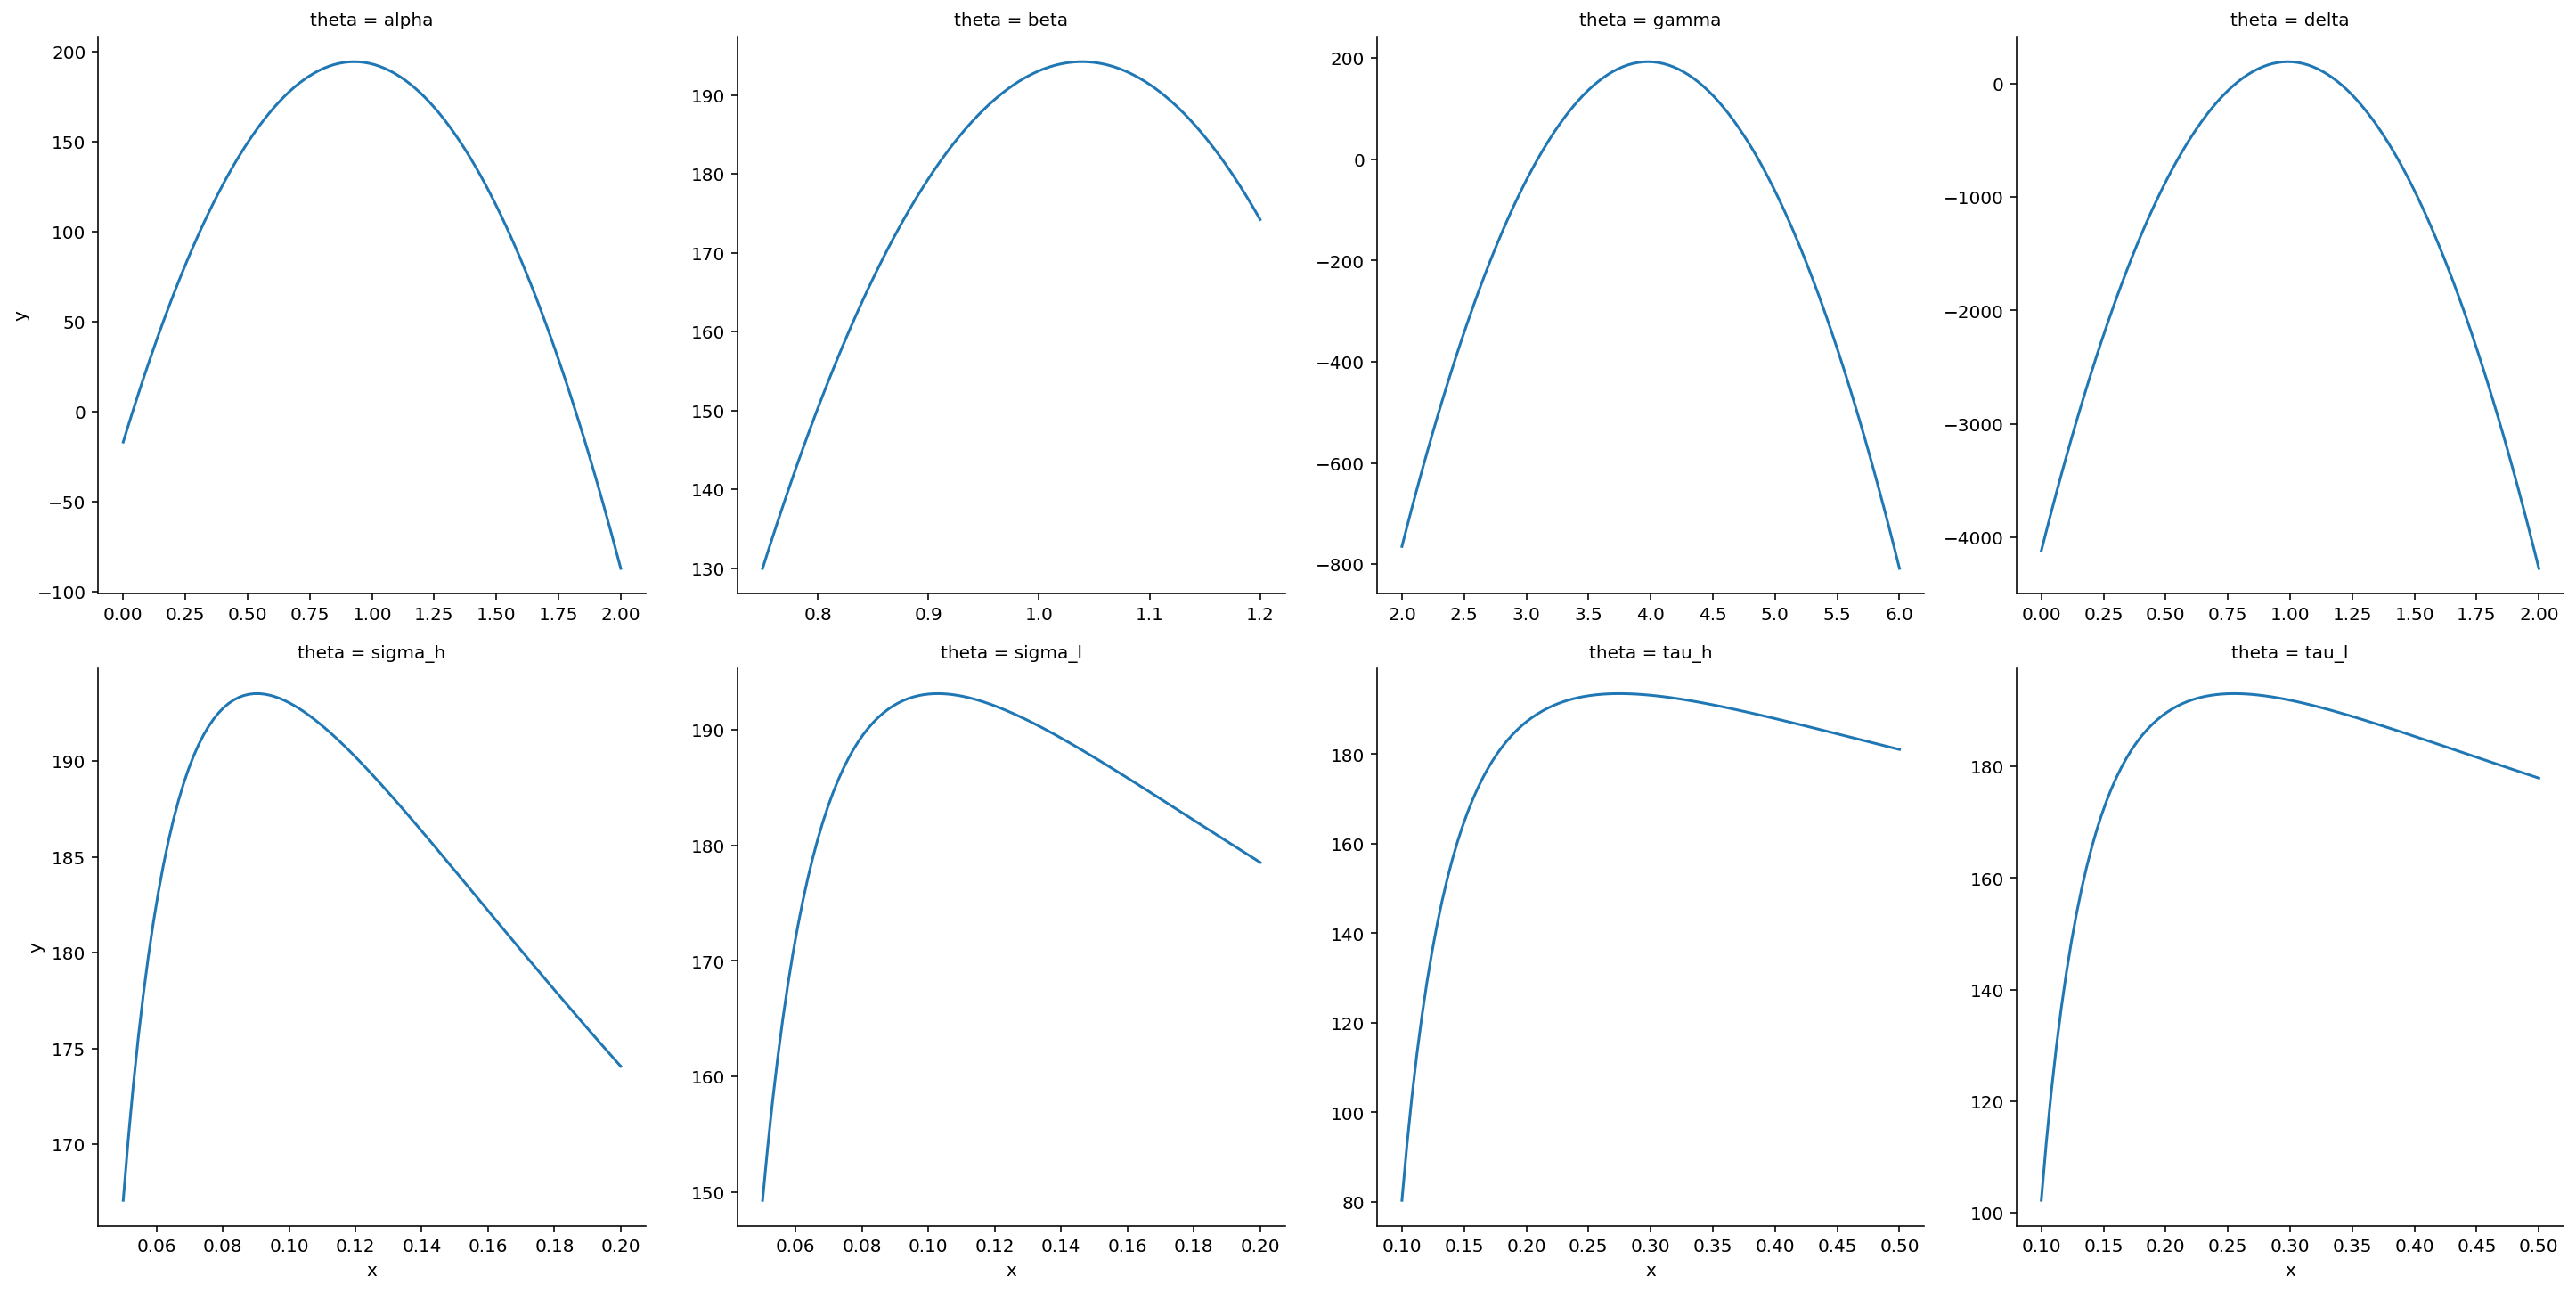

In [21]:
theta_lims = np.array([[0., 2.], [.75, 1.2], [2.0, 6.0], [0., 2.],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot


@jax.jit
def lotvol_loglik(theta):
    return joint_loglik(model=lotvol_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(lotvol_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter

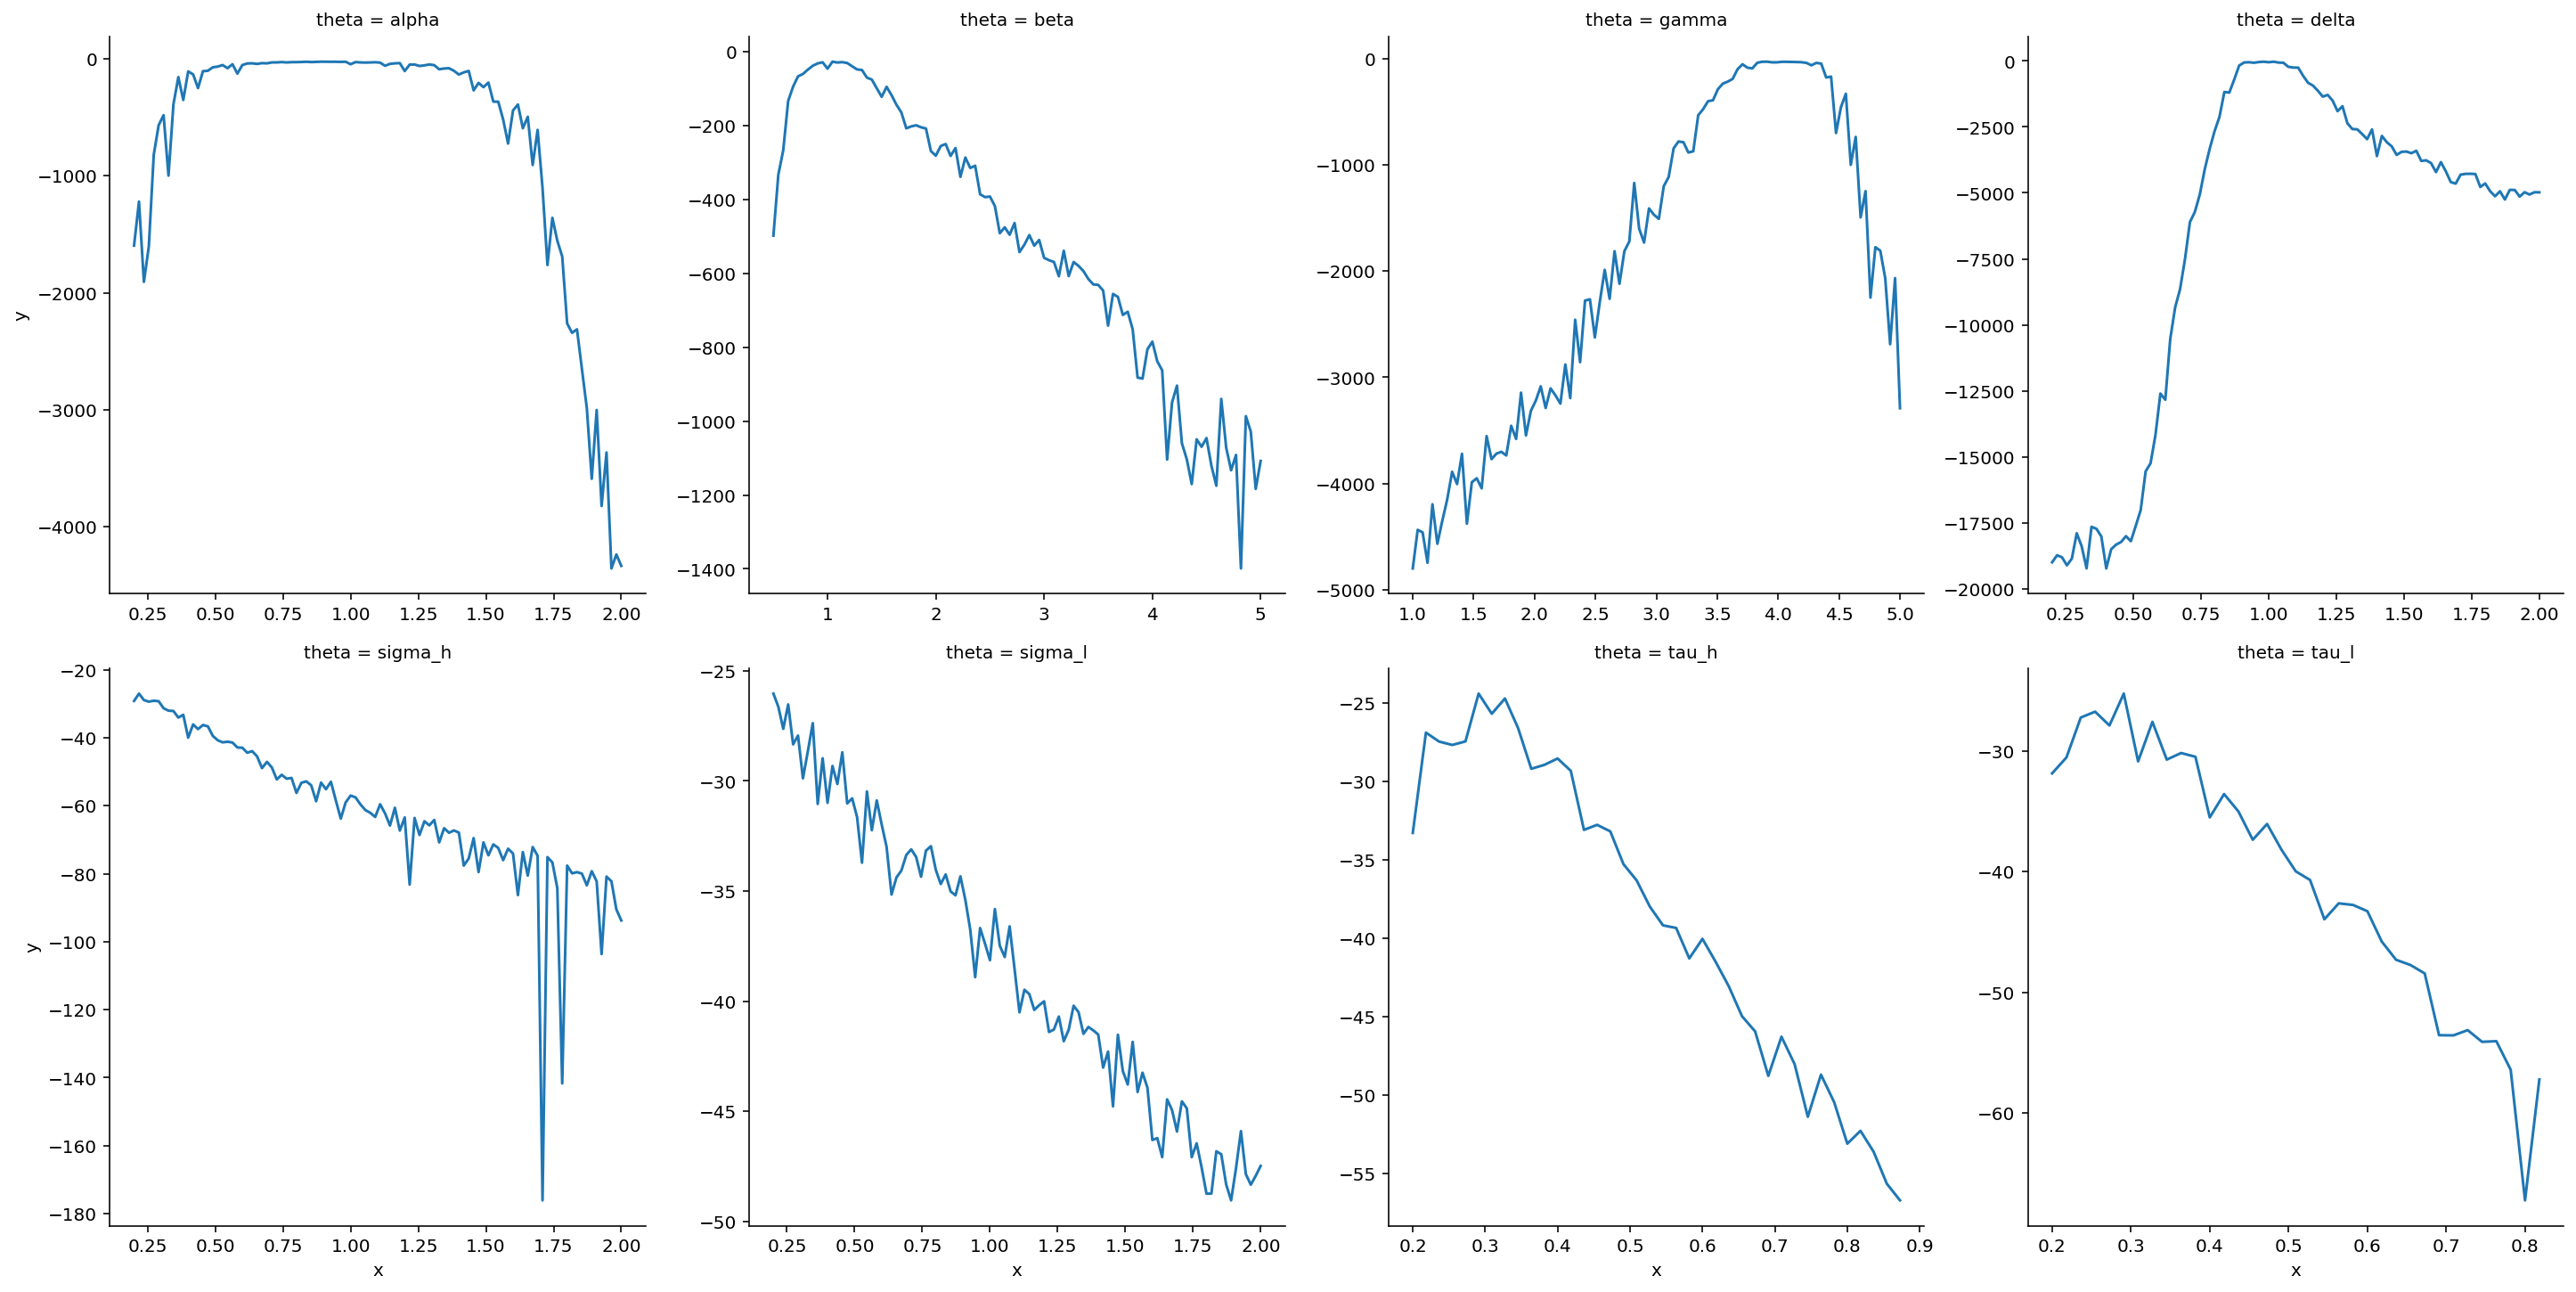

In [26]:
theta_lims = np.array([[0.2, 2.], [0.5, 5.], [1.0, 5.0], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pf(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])

plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter using MVN Approx.

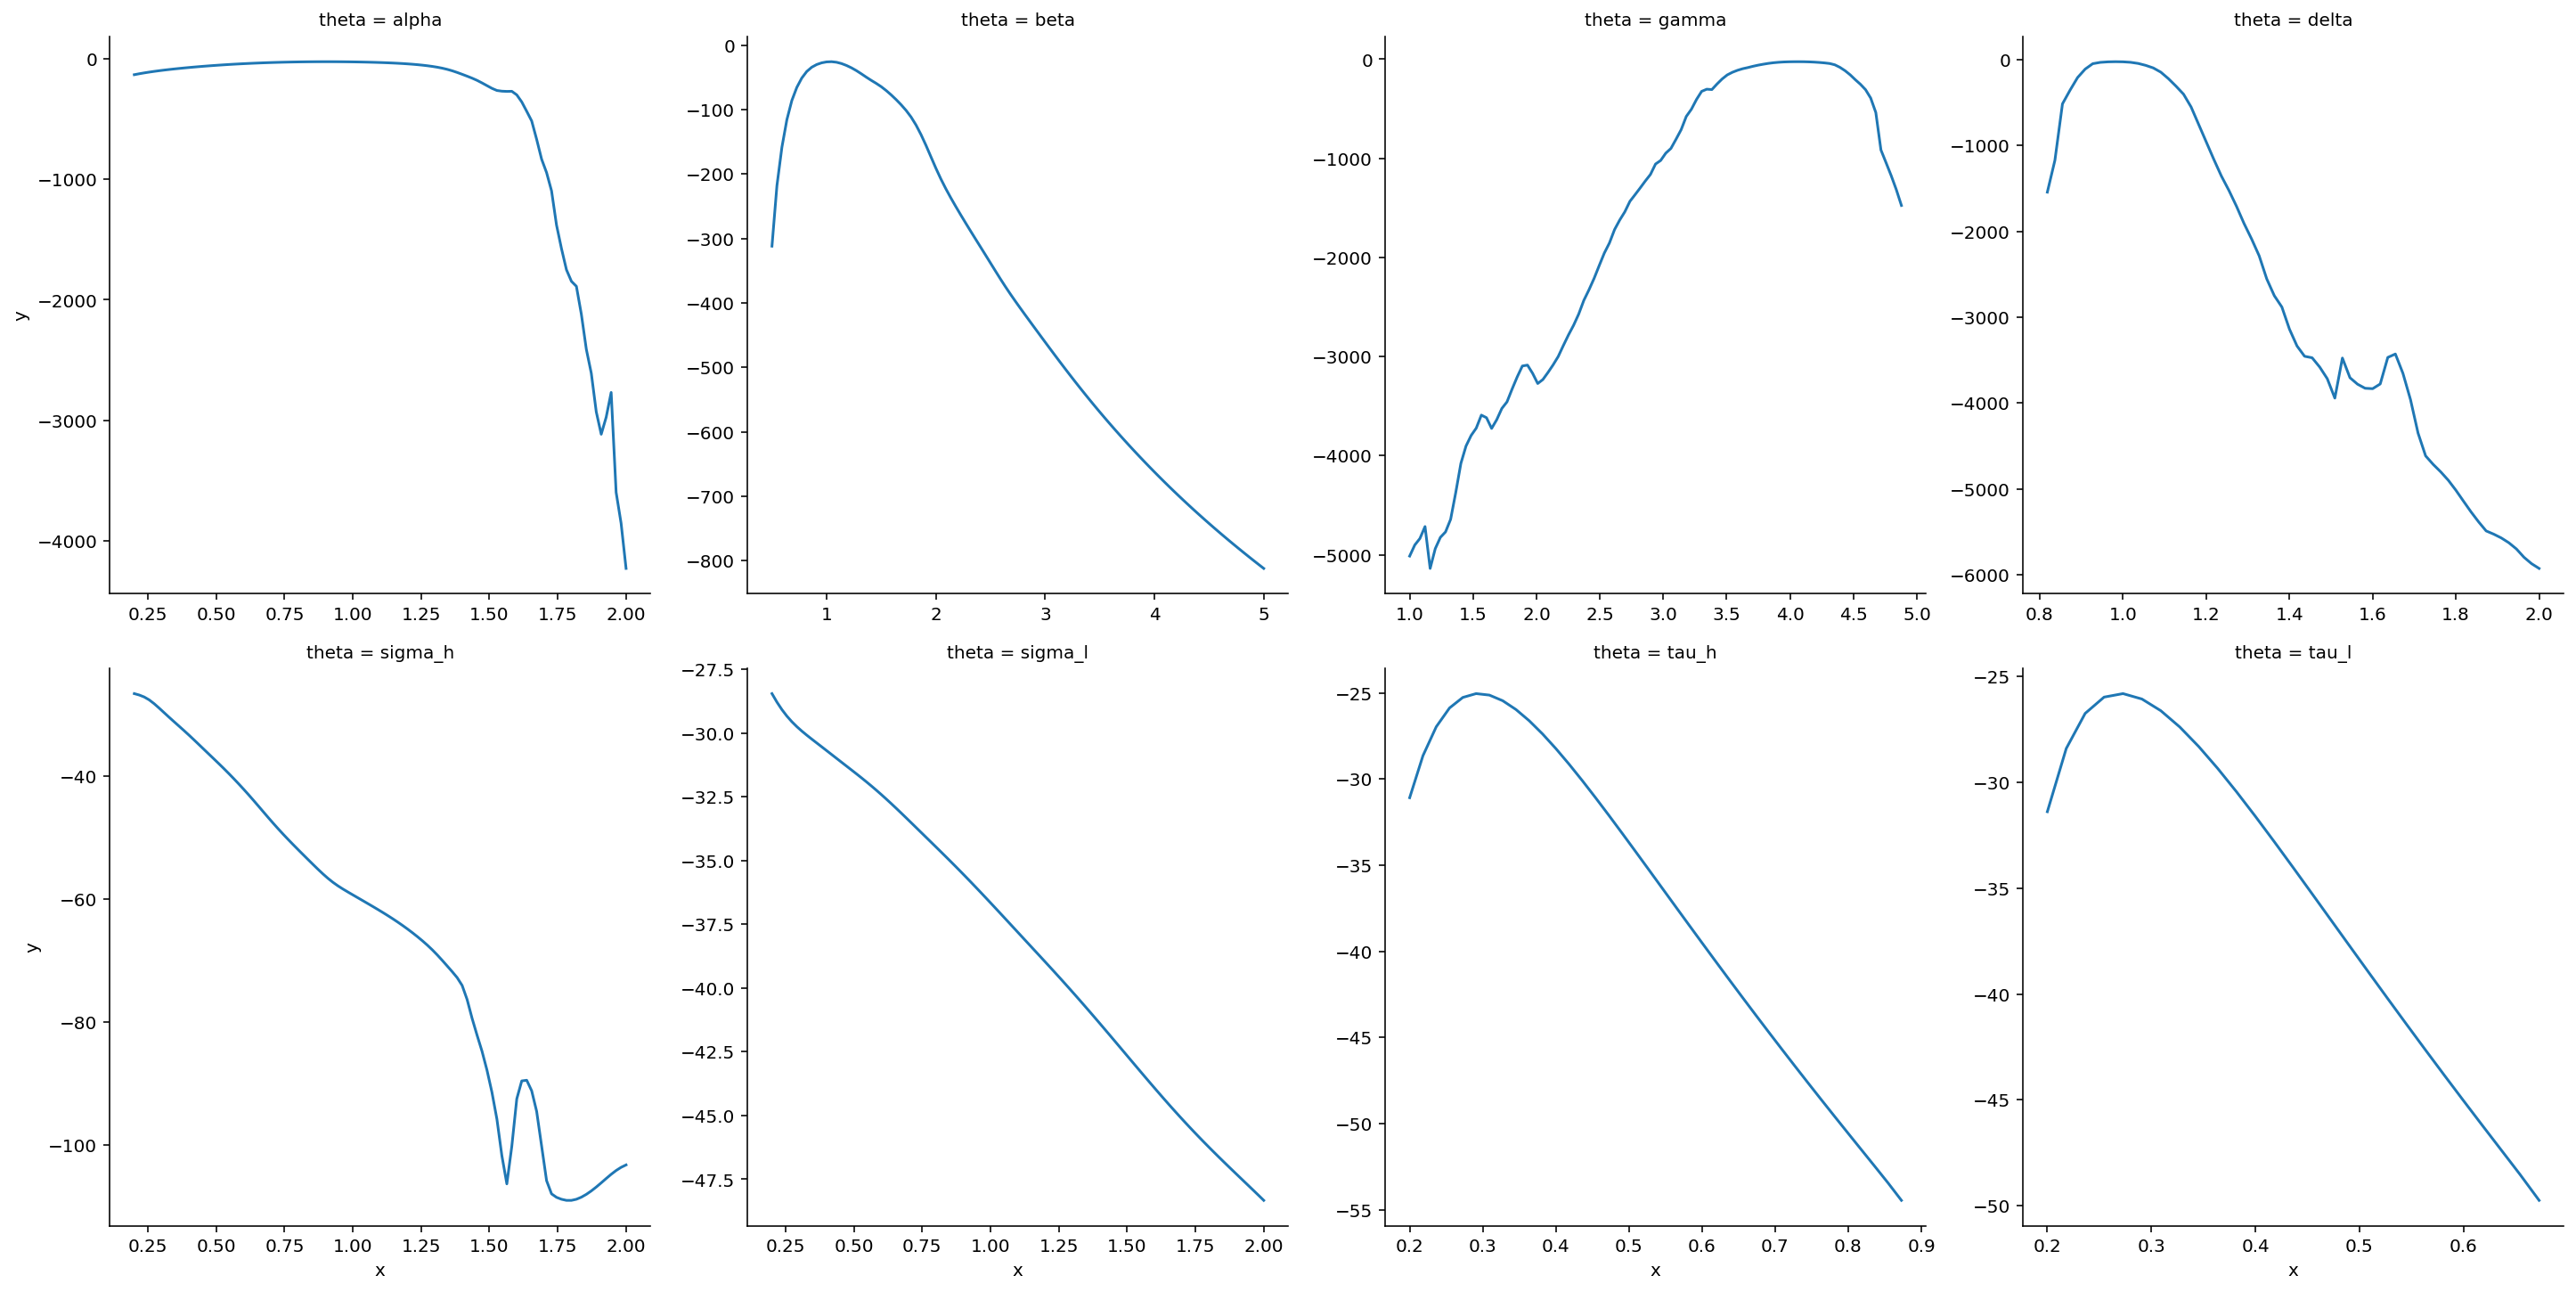

In [25]:
theta_lims = np.array([[0.2, 2.], [0.5, 5.], [1.0, 5.0], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.], [0.2, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pfmvn.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

In [22]:
from pfjax.particle_filter import stoch_opt, get_sum_lweights

In [ ]:
stoch_opt(lotvol_model, jnp.array([1.,1.,4., 1., 0.01, 0.01, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.0000000001, iterations=2000, n_particles=1000,
         mask=np.array([0,1,0,0,0,0,0,0]))

## Scratch

In [ ]:
n_particles = 10

pf_out = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)

In [ ]:
i_obs = 1
print(pf_out["X_particles"][i_obs])
print(y_meas[i_obs])

In [ ]:
theta

In [ ]:
@jax.jit
def lotvol_pflik(theta, key):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])

n_particles = 100

i_theta = 0 # which index of theta to update
theta_min = theta_lims[i_theta][0]
theta_max = theta_lims[i_theta][1]
#theta_min = 3.0
#theta_max = 5.0
theta_seq = np.linspace(theta_min, theta_max, num=n_pts)
ll_seq = np.zeros(theta_seq.shape)
for i in range(n_pts):
    key, subkey = random.split(key)
    theta_tmp = theta
    theta_tmp[i_theta] = theta_seq[i]
    ll_seq[i] = lotvol_pflik(theta_tmp, subkey)
    #theta_tmp = theta_tmp.at[0].set(alpha_seq[i])
    #ll_seq = ll_seq.at[i].set(lotvol_pflik(theta_tmp, subkey))

plt.plot(theta_seq, ll_seq)